In [ ]:
import pandas as pd
import re


green_bonds = pd.read_excel("/Users/Panos/Downloads/green_bonds_with_rating.xlsx", header=0)
conv_bonds_1 = pd.read_excel("/Users/Panos/Downloads/conv_bonds1.xlsx", header=0)
conv_bonds_2 = pd.read_excel("/Users/Panos/Downloads/conv_bonds2.xlsx", header=0)
conv_bonds_3 = pd.read_excel("/Users/Panos/Downloads/conv_bonds_3.xlsx", header=0)

print(green_bonds.columns)
print(conv_bonds_1.columns)
print(conv_bonds_2.columns)
print(conv_bonds_3.columns)

In [ ]:
conv_bonds_3 = conv_bonds_3.drop(columns=['Moody\'s Issuer Rtg'])
conv_bonds_3 = conv_bonds_3.rename(columns={'S&P Issuer Rating': 'Issuer Rating'})

conv_bonds = pd.concat([conv_bonds_1, conv_bonds_2, conv_bonds_3])


In [ ]:
# Define a dictionary that maps Moody's ratings to S&P ratings
ratings_map = {
    'Aaa': 'AAA',
    'Aa1': 'AA+',
    'Aa2': 'AA',
    'Aa3': 'AA-',
    'A1': 'A+',
    'A2': 'A',
    'A3': 'A-',
    'Baa1': 'BBB+',
    'Baa2': 'BBB',
    'Baa3': 'BBB-',
    'Baa3': 'BBB-',
    'Ba1': 'BB+',
    'Ba2': 'BB',
    'Ba3': 'BB-',
    'B1': 'B+',
    'B2': 'B',
    'B3': 'B-',
    'Caa1': 'CCC+',
    'Caa2': 'CCC',
    'Caa3': 'CCC-',
    'Ca': 'C',
    'C': 'D'
}


def replace_missing_sp_issuer(row):
    if pd.isnull(row['S&P Issuer Rating']) or row['S&P Issuer Rating'] == 'NR':
        return ratings_map.get(row['Moody\'s Issuer Rtg'], 'NR')
    else:
        return row['S&P Issuer Rating']
    
def replace_missing_sp(row):
    if pd.isnull(row['S&P Rating']) or row['S&P Rating'] == 'NR':
        return ratings_map.get(row['Moody Rtg'], 'NR')
    else:
        return row['S&P Rating']

# Apply the function to each row
green_bonds['S&P Issuer Rating'] = green_bonds.apply(replace_missing_sp_issuer, axis=1)
green_bonds['S&P Rating'] = green_bonds.apply(replace_missing_sp, axis=1)
conv_bonds['S&P Rating'] = conv_bonds.apply(replace_missing_sp, axis=1)


In [ ]:
conv_bonds = conv_bonds.drop(columns=['Moody Rtg'])
green_bonds = green_bonds.drop(columns=['Moody Rtg', 'Moody\'s Issuer Rtg'])
green_bonds = green_bonds.rename(columns={'S&P Issuer Rating': 'Issuer Rating', 'S&P Rating': 'Bond Rating'})
conv_bonds = conv_bonds.rename(columns={'S&P Rating': 'Bond Rating'})

In [ ]:
total_bonds = pd.concat([green_bonds, conv_bonds], ignore_index=True)
total_bonds = total_bonds.fillna({ 'Project Category': ''})
dropped_rows = total_bonds[total_bonds['Yld to Mty (Mid)'] > 100]

# Print the dropped rows
print("Dropped rows:")
print(dropped_rows)

n_rows_before = total_bonds.shape[0]
total_bonds = total_bonds[total_bonds['Yld to Mty (Mid)'] <= 100]
total_bonds = total_bonds[total_bonds['Yld to Mty (Mid)'] > 0]
n_rows_after = total_bonds.shape[0]

# Number of rows dropped
n_rows_dropped = n_rows_before - n_rows_after

print(n_rows_dropped, n_rows_after)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Using Matplotlib
plt.figure(figsize=(10,6))
plt.hist(total_bonds['Yld to Mty (Mid)'], bins=14, edgecolor='black')
plt.title('Distribution of Yld to Mty (Mid)')
plt.xlabel('Yld to Mty (Mid)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,6))
plt.hist(total_bonds['Yld to Mty (Mid)'], bins=14, edgecolor='black')
plt.title('Distribution of Yld to Mty (Mid)')
plt.xlabel('Yld to Mty (Mid)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()


In [ ]:
from dateutil.relativedelta import relativedelta
from datetime import date


def replace_missing_maturity(row):
    if row['Maturity'] == '#N/A Field Not Applicable':
        return '01/01/2070'
    else:
        return row['Maturity']
    
total_bonds['Maturity'] = total_bonds.apply(replace_missing_maturity, axis=1)

# Split Issue Date into separate columns
total_bonds['Issue Day'] = total_bonds['Issue Date'].apply(lambda x: int(x.split('/')[0]))
total_bonds['Issue Month'] = total_bonds['Issue Date'].apply(lambda x: int(x.split('/')[1]))
total_bonds['Issue Year'] = total_bonds['Issue Date'].apply(lambda x: int(x.split('/')[2]))

# Split Maturity into separate columns
total_bonds['Maturity Day'] = total_bonds['Maturity'].apply(lambda x: int(x.split('/')[0]))
total_bonds['Maturity Month'] = total_bonds['Maturity'].apply(lambda x: int(x.split('/')[1]))
total_bonds['Maturity Year'] = total_bonds['Maturity'].apply(lambda x: int(x.split('/')[2]))


# Function to calculate the number of days between two dates
def days_between(d1, d2):
    return (d2 - d1).days

# Apply the function to each row
total_bonds['Days to Maturity'] = total_bonds.apply(
    lambda row: days_between(
        date(row['Issue Year'], row['Issue Month'], row['Issue Day']),
        date(row['Maturity Year'], row['Maturity Month'], row['Maturity Day'])
    ), 
    axis=1
)

total_bonds = total_bonds.drop(columns=['Maturity', 'Maturity Year', 'Maturity Month', 'Maturity Day', 'Issue Date'])



In [ ]:
total_bonds = pd.get_dummies(total_bonds, columns=['Currency'])


In [ ]:
ratings_mapping = {'AAA': 22, 'AA+': 21, 'AA': 20, 'AA-': 19, 'A+': 18, 'A': 17, 
                   'A-': 16, 'BBB+': 15, 'BBB': 14, 'BBB-': 13, 'BB+': 12, 'BB': 11, 
                   'BB-': 10, 'B+': 9, 'B': 8, 'B-': 7, 'CCC+': 6, 'CCC': 5, 'CCC-': 4, 
                   'CC': 3, 'C': 2, 'D': 1, 'NR': 0}

ratings_mapping = {k: 22-v for k, v in ratings_mapping.items()}

total_bonds['Issuer Rating'] = total_bonds['Issuer Rating'].map(ratings_mapping)
total_bonds['Issuer Rating'] = total_bonds['Issuer Rating'].fillna('0')
total_bonds['Bond Rating'] = total_bonds['Bond Rating'].map(ratings_mapping)


In [ ]:
total_bonds = total_bonds.drop(columns='Issuer Name')

In [ ]:
print(f"val=({total_bonds['Project Category'].iloc[2837]})")
print(type(total_bonds['Project Category'].iloc[2837]))

In [ ]:
total_bonds['Project Category'] = total_bonds['Project Category'].apply(lambda x: False if x == '' else True)

In [ ]:
total_bonds = total_bonds.dropna()

In [ ]:
print(total_bonds.columns)

# Regression

[ 1.76144009e-01  1.20341218e-02  2.27568792e-01 -3.48870367e-02
  1.26817024e-03  1.40906312e-02  3.65190543e-02  4.70351668e-06
 -1.44024420e+00  5.07491146e-01 -1.67129944e+00 -4.22467433e+00
 -2.04281037e-14 -4.48642213e+00  4.71019839e+00 -1.37014950e+00
 -2.96562437e+00  1.22152316e+01 -2.67490089e+00 -8.90594279e-01
 -2.10234396e+00  3.68409368e+00 -1.02891688e+00  7.76041441e-01
 -5.84775326e+00 -2.90626001e+00  4.46174720e+00  4.52322133e+00
 -2.16869759e+00 -1.27886850e+00 -1.53730844e-01 -7.29007504e-01
  1.11692963e+00  1.03040908e+01 -2.28125712e+00 -2.48810989e+00
 -5.40797991e+00 -1.62792275e+00  3.71302997e+00  1.73268212e+00]
Mean MSE=1.6553252227684063, with std=0.31475093137262583
Mean r^2=0.6314618416209659, with std=0.03798368599682557
Mean MAPE=0.22656855424905392, with std=0.04746009494358278


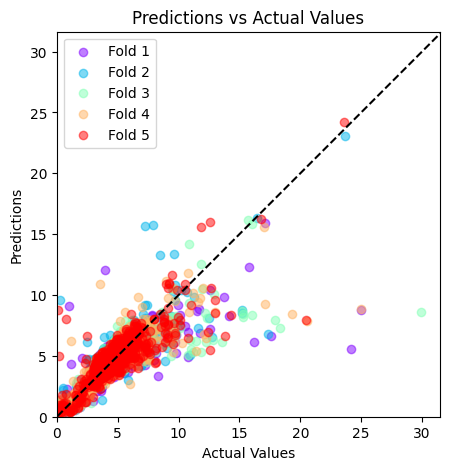

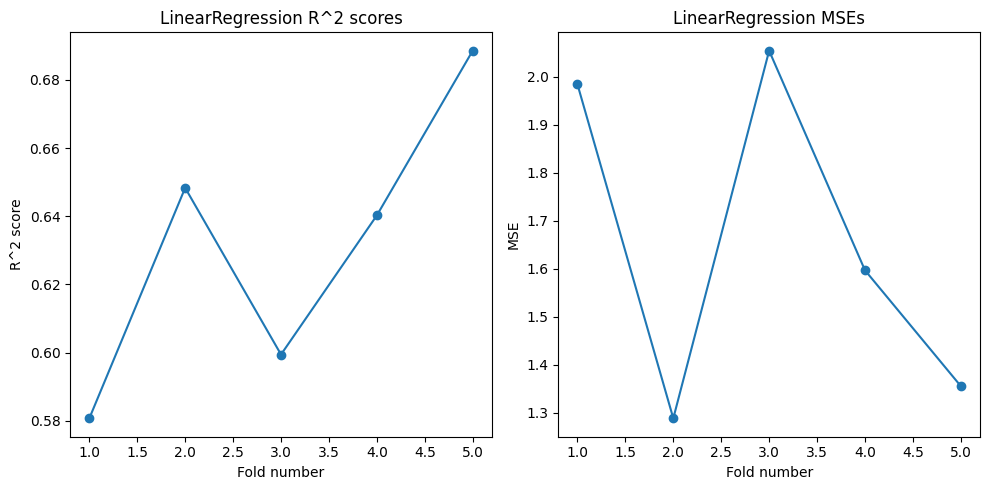

Mean MSE=2.1967782250668937, with std=0.7597848728736474
Mean r^2=0.5077844905361567, with std=0.15252641153094074
Mean MAPE=0.14795103309848742, with std=0.02246660525366827


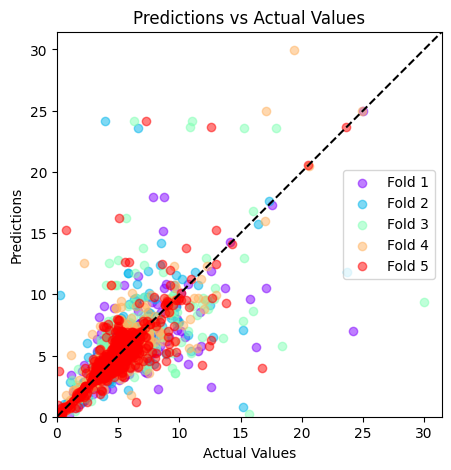

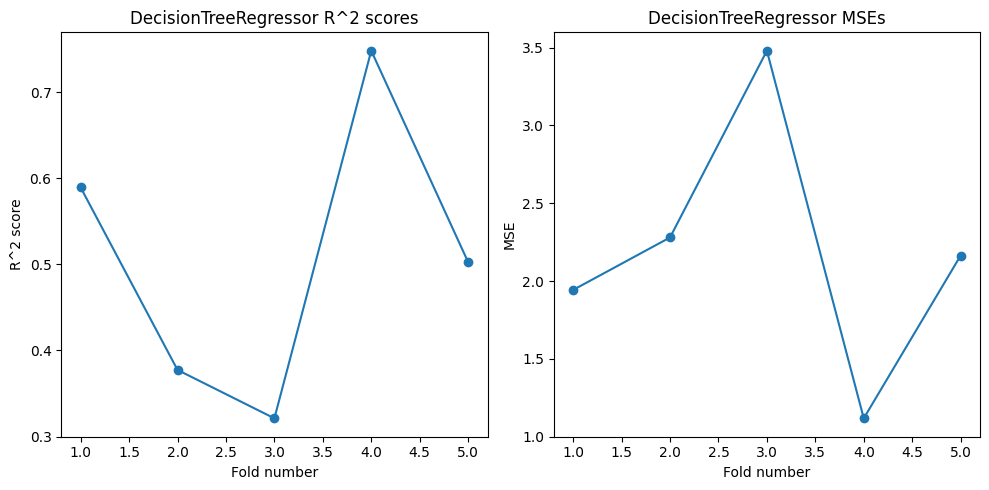

Mean MSE=1.653953851368481, with std=0.31784448469601856
Mean r^2=0.6318353571082534, with std=0.038724771446088394
Mean MAPE=0.22696671565650745, with std=0.047293314608039476


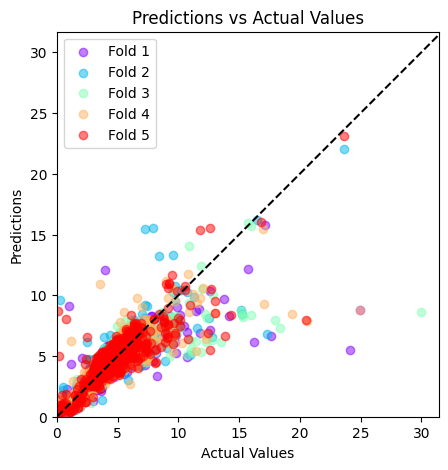

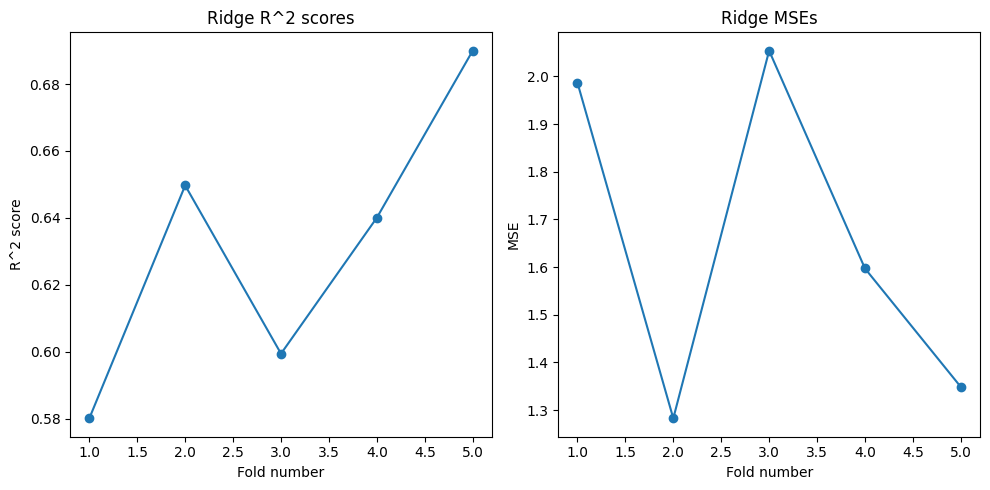

Mean MSE=3.271287100860833, with std=0.46395680133888645
Mean r^2=0.26961920980860965, with std=0.027262588724810417
Mean MAPE=0.632653727360846, with std=0.08197745366909373


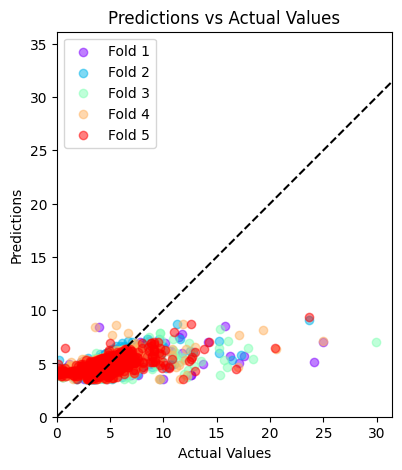

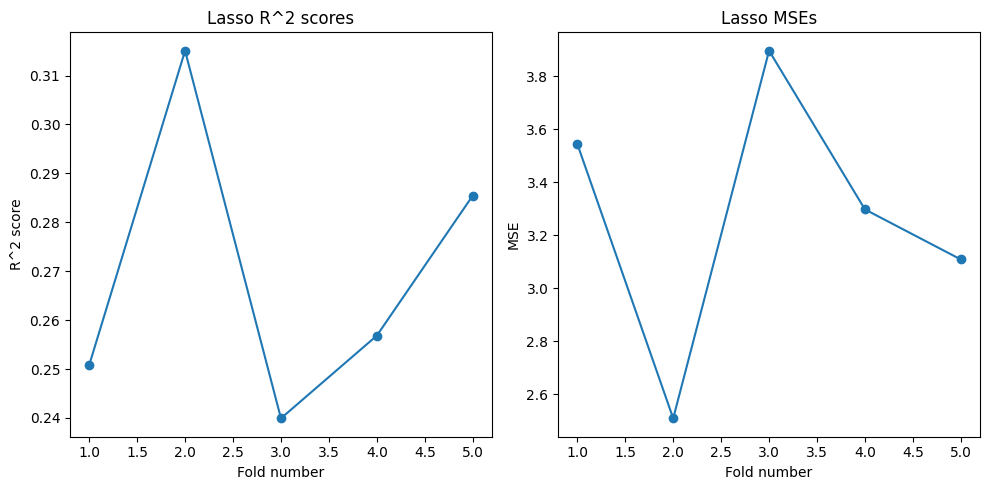

Mean MSE=2.9920243943655342, with std=0.43429327511266536
Mean r^2=0.3319829142473453, with std=0.030082552965323073
Mean MAPE=0.5802928662669423, with std=0.0728457560831311


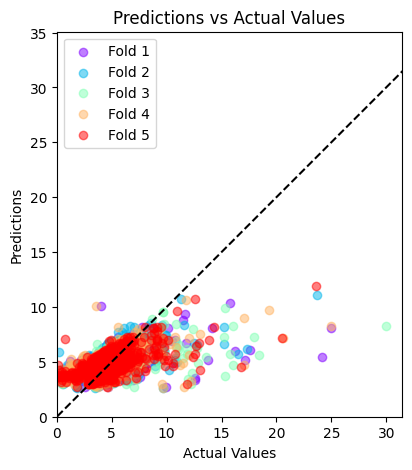

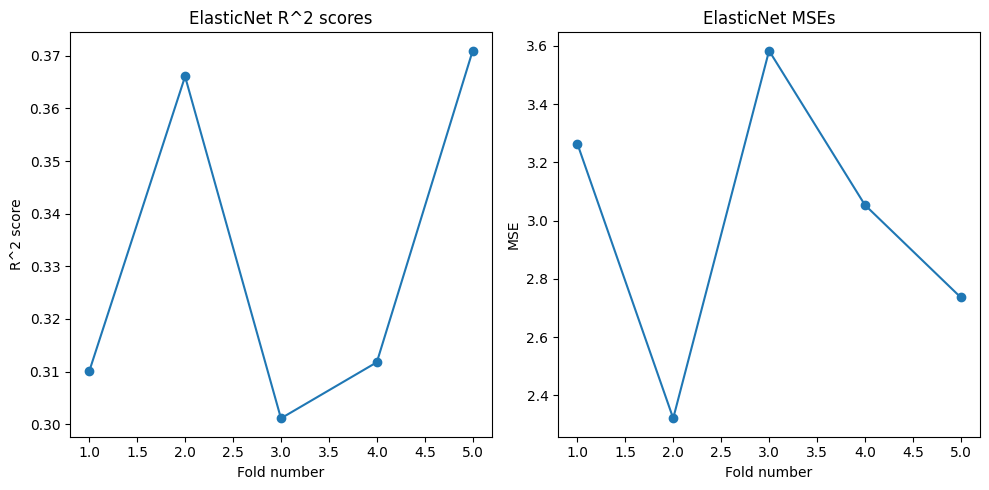

Mean MSE=3.8170842226590254, with std=0.42627314306666975
Mean r^2=0.14448239141644525, with std=0.020352834634057983
Mean MAPE=0.6777389733682375, with std=0.08454158875477397


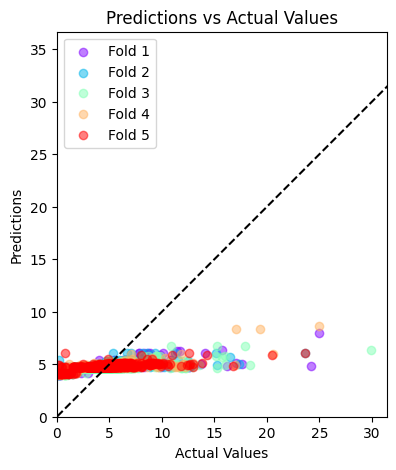

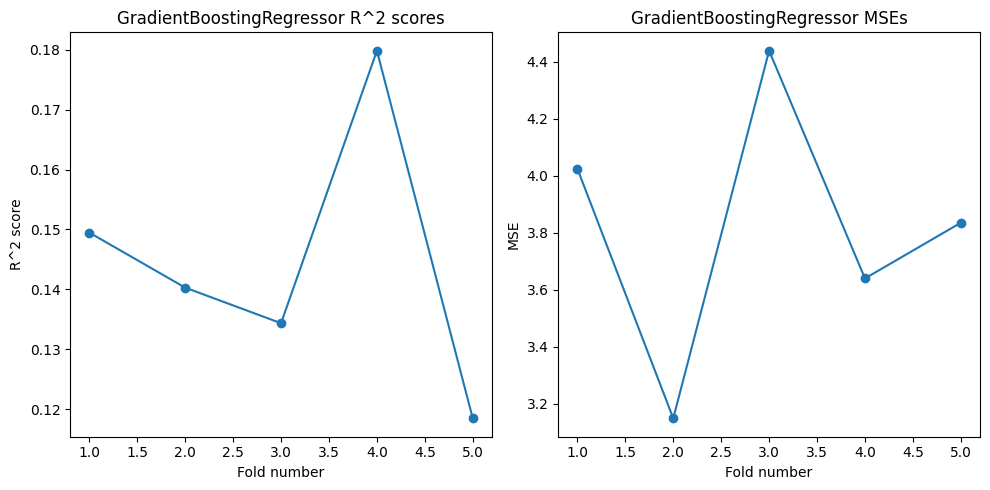

Mean MSE=1.06136918297459, with std=0.22646965038999284
Mean r^2=0.7611637203632784, with std=0.048214027894326154
Mean MAPE=0.13104912996511472, with std=0.0427687811384988


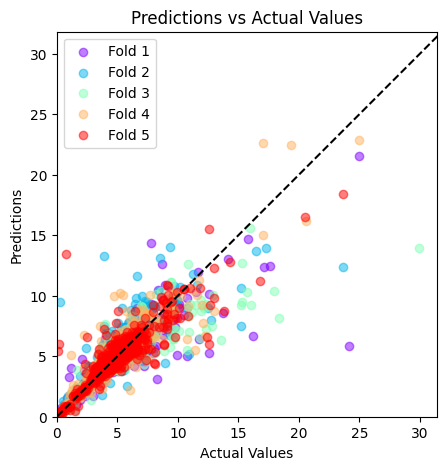

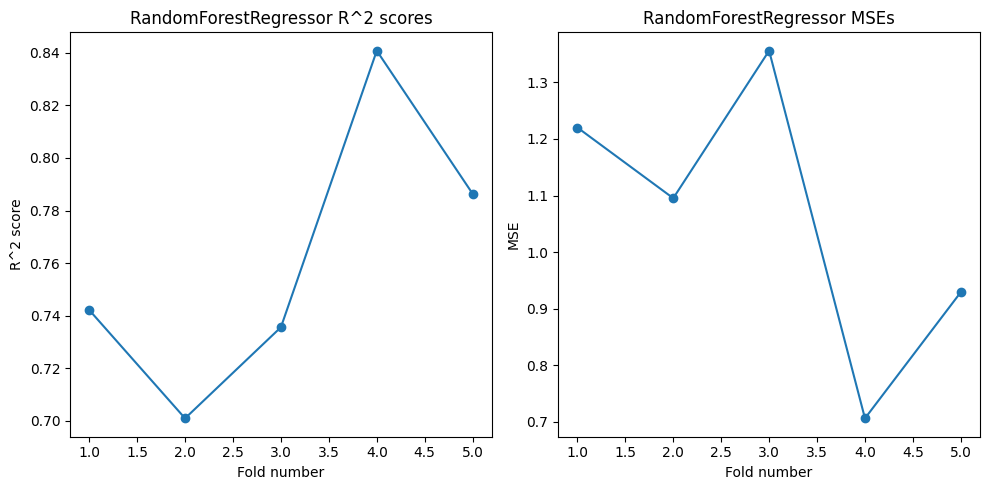

Mean MSE=4.411982978102721, with std=0.5158701264861363
Mean r^2=0.01213217991425608, with std=0.009547760967373769
Mean MAPE=0.7249161513887179, with std=0.08934795822839545


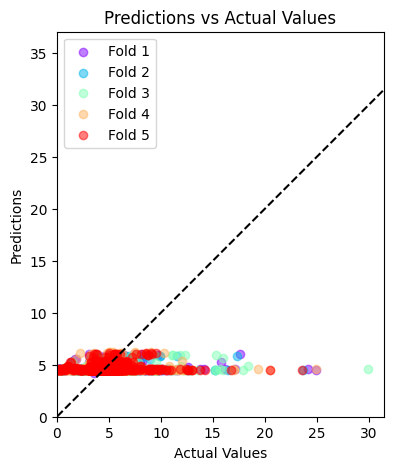

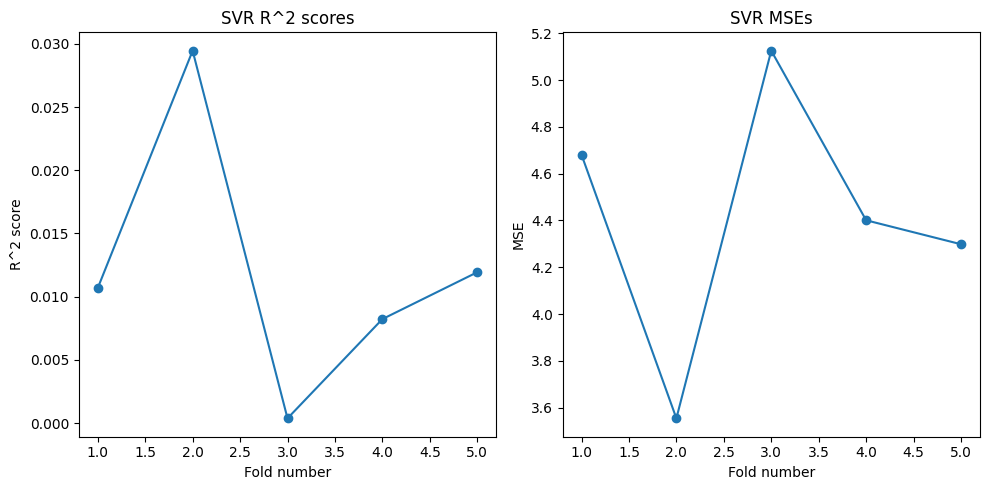

In [152]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Check for NaN values and remove those rows
# total_bonds = total_bonds.dropna()

# # Transform the 'Project Category' column
# total_bonds['Project Category'] = total_bonds['Project Category'].apply(lambda x: False if x == '' else True)

# Define target and features
y = total_bonds['Yld to Mty (Mid)']
X = total_bonds.drop('Yld to Mty (Mid)', axis=1)

# Initialize the scaler
scaler = StandardScaler()

# Initialize the models
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    Ridge(alpha=0.1),
    Lasso(),
    ElasticNet(alpha=0.5),
    GradientBoostingRegressor(learning_rate=0.001, n_estimators=200),
    RandomForestRegressor(n_estimators=1000),
    SVR(epsilon=0.1, cache_size=700)
]

# Initialize KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)


for model in models:
    model_name = model.__class__.__name__
    scores = []
    mses = []
    mapes = []
    fold_preds = []
    fold_truths = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the scaler on the training set and transform both sets
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)

        scores.append(score)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mses.append(mse)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mapes.append(mape)
        fold_truths.append(y_test)
        fold_preds.append(y_pred)
        # plt.scatter(y_test, y_pred)
        # plt.xlabel('True Values')
        # plt.ylabel('Predictions')
        # plt.title('Predictions vs True Values')
        # plt.axis('equal')
        # plt.axis('square')
        # plt.xlim([0,plt.xlim()[1]])
        # plt.ylim([0,plt.ylim()[1]])
        # _ = plt.plot([-100, 100], [-100, 100])
        # plt.show()
    if (model_name == 'LinearRegression'):
        print(model.coef_)
    print(f'Mean MSE={np.mean(mses)}, with std={np.std(mses)}')
    print(f'Mean r^2={np.mean(scores)}, with std={np.std(scores)}')
    print(f'Mean MAPE={np.mean(mapes)}, with std={np.std(mapes)}')

    # Create color map with a unique color for each fold
    colors = plt.cm.rainbow(np.linspace(0, 1, 5))

    # Create the figure
    plt.figure(figsize=(10,5))

    for fold in range(5):
        # Scatter the predictions against the actual values for each fold
        plt.scatter(fold_truths[fold], fold_preds[fold], color=colors[fold], alpha=0.5, label=f'Fold {fold+1}')
    # Set title and labels
    plt.title('Predictions vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    # Plot the identity line
    _ = plt.plot([-100, 100], [-100, 100], color='black', linestyle='--')
    # Add a legend
    plt.legend()
    # Show the plot
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, kf.get_n_splits() + 1), scores, marker='o')
    plt.xlabel('Fold number')
    plt.ylabel('R^2 score')
    plt.title(f'{model_name} R^2 scores')
    
    # Plot MSEs
    plt.subplot(1, 2, 2)
    plt.plot(range(1, kf.get_n_splits() + 1), mses, marker='o')
    plt.xlabel('Fold number')
    plt.ylabel('MSE')
    plt.title(f'{model_name} MSEs')

    # plt.subplot(1,3,3)
    # plt.scatter(y_test, y_pred)
    # plt.xlabel('True Values')
    # plt.ylabel('Predictions')
    # plt.title('Prediction vs True Value - Fold {}'.format(i+1))
    # plt.axis('equal')
    # plt.axis('square')
    # plt.xlim([0,plt.xlim()[1]])
    # plt.ylim([0,plt.ylim()[1]])
    # _ = plt.plot([-100, 100], [-100, 100])
    
    plt.tight_layout()
    plt.show()


In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Define the number of features (don't include 'Issuer' and 'Yld to Mty (Mid)')
num_features_ytm = total_bonds.drop(['Yld to Mty (Mid)'], axis=1).shape[1]

# Split your data into features (X) and target (y)
X_num = total_bonds.drop(['Yld to Mty (Mid)'], axis=1)
y = total_bonds['Yld to Mty (Mid)']

# Convert all to numpy array and ensure type compatibility
X_num = X_num.to_numpy().astype('float32')
y = y.to_numpy().astype('float32')
y = y.round(decimals=4)

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelYTM(nn.Module):
    def __init__(self, num_features_ytm):
        super(ModelYTM, self).__init__()
        self.num_features_ytm = num_features_ytm
        
        self.dense1 = nn.Linear(num_features_ytm, 65)
        self.dense2 = nn.Linear(65, 65)
        # self.dropout2 = nn.Dropout(0.2)
        self.dense4 = nn.Linear(65, 65)
        self.dense5 = nn.Linear(65, 5)
        self.output_layer = nn.Linear(5, 1)
        
    def forward(self, num_input):

        x = F.leaky_relu(self.dense1(num_input))
        x = F.leaky_relu(self.dense2(x))
        x = F.leaky_relu(self.dense4(x))
        x = F.leaky_relu(self.dense5(x))
        output = self.output_layer(x)
        
        return output


In [ ]:
# import numpy as np

# X_num_test = X_num
# nan_indices = np.where(np.isnan(X_num_test))
# print(nan_indices)
# nan_indices = np.where(np.isnan(X_num_test))
# print(nan_indices)
# scaler_rtg = StandardScaler() # make new scaler, we will need the old later to scale the output of the model
# X_num_test = scaler_rtg.fit_transform(X_num_test)
# nan_indices = np.where(np.isnan(X_num_test))

# print(nan_indices)

Test MSE: 1.3410361
Test MAPE: 0.16468678


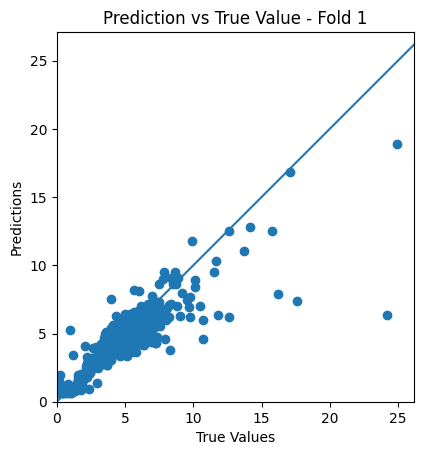

Test MSE: 1.1005635
Test MAPE: 0.20914835


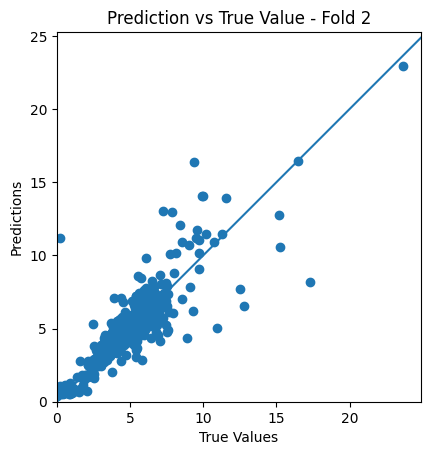

Test MSE: 1.3181964
Test MAPE: 0.13830487


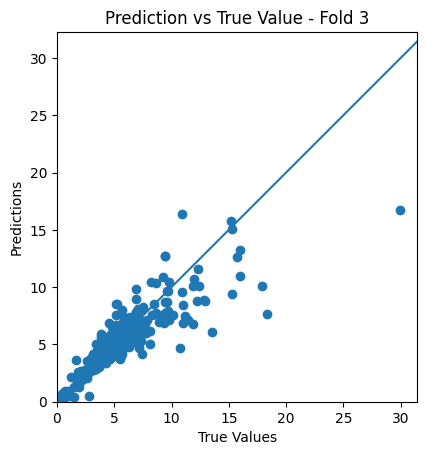

Test MSE: 0.8944203
Test MAPE: 0.17672633


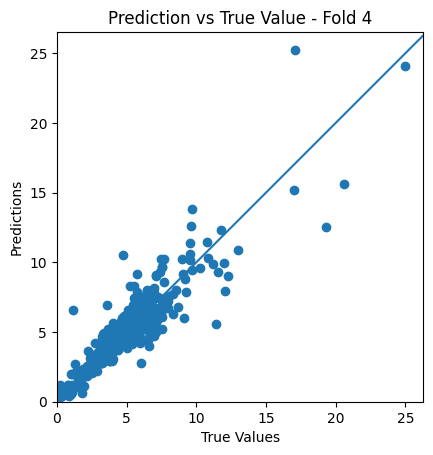

Test MSE: 1.0924221
Test MAPE: 0.2705994


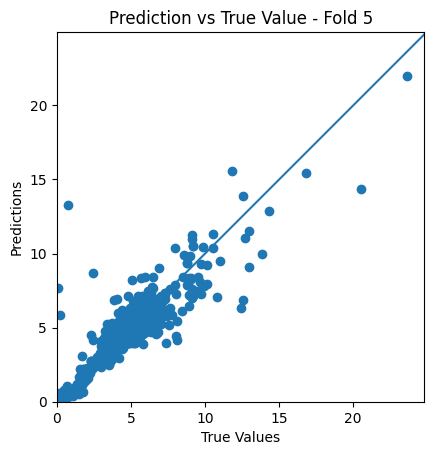

MSE: 1.1493 +/- 0.1648
R^2: 0.7413 +/- 0.0337
MAPE: 0.1919 +/- 0.0455


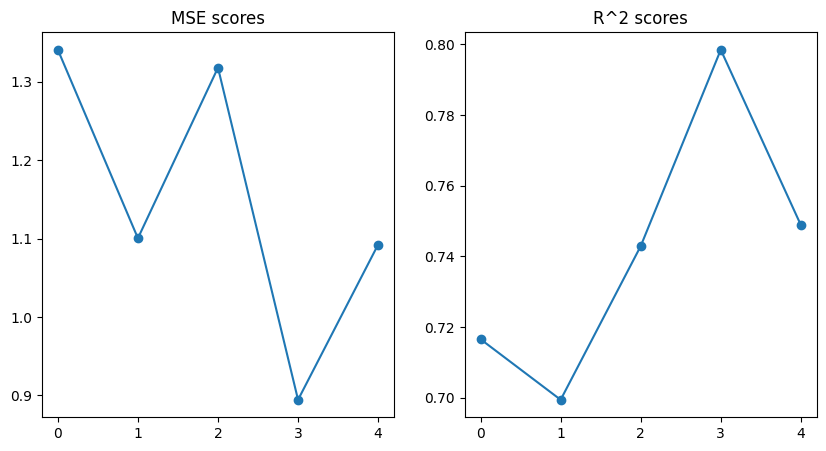

In [148]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define a training step
def train_step(inputs_num, targets, model, loss_function, optimizer):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs_num)
    loss = loss_function(outputs, targets.view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

# Initialize the KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the scores for each fold
mse_scores = []
r2_scores = []
mapes = []

f = 0
# Loop through each fold
for train_index, test_index in kf.split(X_num, y):
    X_train, X_test = X_num[train_index], X_num[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for i in range(X_train.shape[1]):
        scaler = StandardScaler()
        X_train[:, i] = scaler.fit_transform(X_train[:, i].reshape(-1, 1)).flatten()  # scale each column
        X_test[:, i] = scaler.transform(X_test[:, i].reshape(-1, 1)).flatten()  # scale each column using the scaler fitted on the training set

    X_train = X_train.astype('float32')  # convert the datatype
    X_test = X_test.astype('float32')  # convert the datatype

    X_train = torch.tensor(X_train)
    X_test = torch.tensor(X_test)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)


    # Create a new model for each fold
    model_ytm = ModelYTM(num_features_ytm=num_features_ytm)

    # Define a loss function and optimizer for this fold
    loss_function = nn.MSELoss()
    optimizer = optim.Adagrad(model_ytm.parameters(), lr=0.1)

    # Convert to TensorDataset and create a DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

    # Train the model for each epoch
    for epoch in range(20):
        for inputs_num, targets in train_dataloader:
            train_step(inputs_num, targets, model_ytm, loss_function, optimizer)

    # Evaluate the model
    model_ytm.eval()
    with torch.no_grad():
        y_pred = model_ytm(X_test).numpy()

    # torch.save(model_ytm.state_dict(), f'model_ytm_fold{i+1}.pth')

    # Calculate and store the scores
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2_score(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mapes.append(mape)

    print("Test MSE:", mse)
    print("Test MAPE:", mape)

    plt.figure(f)
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Prediction vs True Value - Fold {}'.format(f+1))
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])
    plt.show()
    f += 1

# Print the mean and standard deviation of the MSE and R^2 scores
print('MSE: %.4f +/- %.4f' % (np.mean(mse_scores), np.std(mse_scores)))
print('R^2: %.4f +/- %.4f' % (np.mean(r2_scores), np.std(r2_scores)))
print('MAPE: %.4f +/- %.4f' % (np.mean(mapes), np.std(mapes)))

# Plot the MSE scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mse_scores, marker='o')
plt.title('MSE scores')

# Plot the R^2 scores
plt.subplot(1, 2, 2)
plt.plot(r2_scores, marker='o')
plt.title('R^2 scores')
plt.show()


In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelYTM(nn.Module):
    def __init__(self, num_features_ytm):
        super(ModelYTM, self).__init__()
        self.num_features_ytm = num_features_ytm
        
        self.dense1 = nn.Linear(num_features_ytm, 64)
        self.dense2 = nn.Linear(64, 64)
        self.dense3 = nn.Linear(64, 64)
        self.dense4 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
        
    def forward(self, num_input):

        x = self.dense1(num_input)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        output = self.output_layer(x)
        
        return output


Test MSE: 5.7698793
Test MAPE: 0.6927966


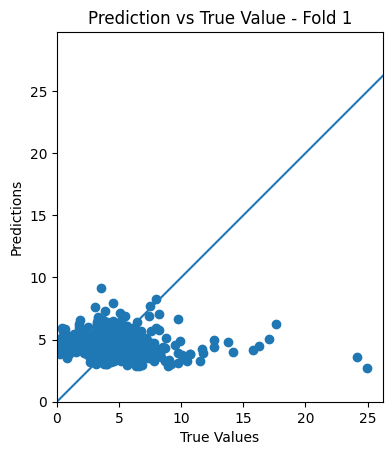

Test MSE: 30877.834
Test MAPE: 14.2514515


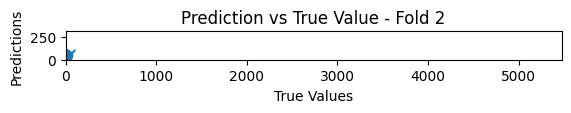

KeyboardInterrupt: 

In [99]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define a training step
def train_step(inputs_num, targets, model, loss_function, optimizer):
    model.train()
    optimizer.zero_grad()
    outputs = model(inputs_num)
    loss = loss_function(outputs, targets.view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

# Initialize the KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the scores for each fold
mse_scores = []
r2_scores = []
mapes = []

f = 0
# Loop through each fold
for train_index, test_index in kf.split(X_num, y):
    X_train, X_test = X_num[train_index], X_num[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = X_train.astype('float32')  # convert the datatype
    X_test = X_test.astype('float32')  # convert the datatype

    X_train = torch.tensor(X_train)
    X_test = torch.tensor(X_test)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)


    # Create a new model for each fold
    model_ytm = ModelYTM(num_features_ytm=num_features_ytm)

    # Define a loss function and optimizer for this fold
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model_ytm.parameters(), lr=0.001)

    # Convert to TensorDataset and create a DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

    # Train the model for each epoch
    for epoch in range(20):
        for inputs_num, targets in train_dataloader:
            train_step(inputs_num, targets, model_ytm, loss_function, optimizer)

    # Evaluate the model
    model_ytm.eval()
    with torch.no_grad():
        y_pred = model_ytm(X_test).numpy()

    # torch.save(model_ytm.state_dict(), f'model_ytm_fold{i+1}.pth')

    # Calculate and store the scores
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2_score(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mapes.append(mape)

    print("Test MSE:", mse)
    print("Test MAPE:", mape)

    plt.figure(f)
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Prediction vs True Value - Fold {}'.format(f+1))
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])
    plt.show()
    f += 1

# Print the mean and standard deviation of the MSE and R^2 scores
print('MSE: %.4f +/- %.4f' % (np.mean(mse_scores), np.std(mse_scores)))
print('R^2: %.4f +/- %.4f' % (np.mean(r2_scores), np.std(r2_scores)))
print('MAPE: %.4f +/- %.4f' % (np.mean(mapes), np.std(mapes)))

# Plot the MSE scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mse_scores, marker='o')
plt.title('MSE scores')

# Plot the R^2 scores
plt.subplot(1, 2, 2)
plt.plot(r2_scores, marker='o')
plt.title('R^2 scores')
plt.show()
